# **IMAGE CAPTION GENERATOR**

## **Data Source :**

We use the dataset available at https://www.kaggle.com/datasets/adityajn105/flickr8k

### **About Dataset -**

A new benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. … The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations

Connect google colab with google drive.

In [1]:
from google.colab import drive

## **Import Libraries**

In [2]:
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

from nltk.translate.bleu_score import corpus_bleu

Set the base directory path into the variable **"BASE_DIR"**.

In [3]:
BASE_DIR = '/content/drive/MyDrive/image_caption'

Now, the **VGG16 model** is being loaded and then restructured by creating a new model that takes the same input as the original model but outputs the second-to-last layer's output.

In [4]:
model = VGG16()                          # load vgg16 model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)           # restructure the model
print(model.summary())                               # summarize

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

The features of images are being extracted using the **VGG16 model** and stored in a dictionary called **"features"**.



*   Initialize an empty dictionary called "features" to store the extracted features of the images. Then, set the "directory" variable to the path where the images are located, i.e **"BASE_DIR"**.

*   Iterate over each image file name in the specified directory using the **os.listdir()** function. The **tqdm** function provides a progress bar to track the iteration.

*   Construct the full path to the image file by concatenating the directory path and the image name. Then load the image using the **load_img** function from the Keras library. The image is resized to a target size of (224, 224) pixels.

*   Convert the loaded image to a NumPy array representation using the **img_to_array** function.

*   Then reshape data for the model and store it into the **"image"** variable. After this, preprocess the image for vgg model by using **preprocess_input** function.

*   Extract features, and get image id then store it into the **"image_id"** variable. Finally store the features of images.







In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name                 # concatenate the complete path
    image = load_img(img_path, target_size=(224, 224))       # load the image from file
    image = img_to_array(image)                 # convert image pixels to numpy array
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))               # reshape data for model
    image = preprocess_input(image)               # preprocess image for vgg
    feature = model.predict(image, verbose=0)             # extract features
    image_id = img_name.split('.')[0]                # get image ID
    features[image_id] = feature                  # store feature

  0%|          | 0/8118 [00:00<?, ?it/s]

## **Load the Captions Data**

Now, a file named **"captions.txt"** is being read and its contents are stored in the variable **"captions_doc"**.

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

Then, mapping of images to captions is created using the contents of the **"captions.txt"** file. 

In [7]:
# create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):              # process lines
    tokens = line.split(',')                     # split the line by comma(,)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]              # remove extension from image ID
    caption = " ".join(caption)                   # convert caption list to string
    if image_id not in mapping:                  # create list if needed
        mapping[image_id] = []
    mapping[image_id].append(caption)            # store the caption

  0%|          | 0/40456 [00:00<?, ?it/s]

Let's see the size of length.

In [8]:
len(mapping)

8091

Define a function named **"clean"** that processes and cleans the captions in the given mapping.

A loop iterates over every caption (one at a time), then convert all the captions into lower case body.

Remove all digits, special characters etc. from the captions and also delete additional spaces.

Then add a "startseq" and "endseq" tags at the start and end of the captions.

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]                            # take one caption at a time
            caption = caption.lower()                           # convert to lowercase
            caption = caption.replace('[^A-Za-z]', '')         # delete digits, special chars, etc., 
            caption = caption.replace('\s+', ' ')              # delete additional spaces
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'   # add start and end tags to the caption
            captions[i] = caption

Before preprocessing the text.

In [10]:
mapping['1016887272_03199f49c4']                   # before preprocess of text

['A collage of one person climbing a cliff .',
 'A group of people are rock climbing on a rock climbing wall .',
 'A group of people climbing a rock while one man belays',
 'Seven climbers are ascending a rock face whilst another man stands holding the rope .',
 'Several climbers in a row are climbing the rock while the man in red watches and holds the line .']

Perform preprocessing over the text.

In [11]:
clean(mapping)                            # preprocess the text

After preprocessing the text.

In [12]:
mapping['1016887272_03199f49c4']             # after preprocess of text

['startseq collage of one person climbing cliff endseq',
 'startseq group of people are rock climbing on rock climbing wall endseq',
 'startseq group of people climbing rock while one man belays endseq',
 'startseq seven climbers are ascending rock face whilst another man stands holding the rope endseq',
 'startseq several climbers in row are climbing the rock while the man in red watches and holds the line endseq']

Now, all the captions from the "mapping" dictionary are extracted and stored in a list called **"all_captions"**. 

In [13]:
all_captions = []                 # empty list to store the extracted captions
for key in mapping:               # iterates over each key in the mapping dictionary
    for caption in mapping[key]:       #  iterates over each caption
        all_captions.append(caption)        # add captions in list

In [14]:
len(all_captions)

40455

In [15]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

A **"Tokenizer"** object is created and used to tokenize the text data represented by the **"all_captions"** list.

In [16]:
# tokenize the text
tokenizer = Tokenizer()                     # initializes a okenizer object          
tokenizer.fit_on_texts(all_captions)          # fits the Tokenizer on the text data
vocab_size = len(tokenizer.word_index) + 1     # calculates the vocabulary size

Let's see the vocabulary size based on the word index generated by the Tokenizer.

In [17]:
vocab_size

8485

Now, the maximum length of captions in terms of the number of words is calculated using a generator expression and store it into the variable named **"max_length"**.

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)          # get maximum length of the caption available
max_length

35

The image IDs from the "mapping" dictionary are extracted and split into train and test sets.

In [19]:
image_ids = list(mapping.keys())              # retrieves keys from mapping dictionary
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Now, define a data generator function called **"data_generator"** that is used to generate data in batches for training a model.

In [20]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()                 # initializes 3 empty lists
    n = 0
    while 1:
        for key in data_keys:              # loop iterates over the image IDs in data_keys list
            n += 1
            captions = mapping[key]
            for caption in captions:                          # process each caption
                seq = tokenizer.texts_to_sequences([caption])[0]                 # encode the sequence
                for i in range(1, len(seq)):                      # split the sequence into X, y pairs
                    in_seq, out_seq = seq[:i], seq[i]             # split into input and output pairs
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]              # pad input sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]           # encode output sequence
                    
                    X1.append(features[key][0])                       # store the sequences
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:                        # checks if the number of processed samples = specified batch size
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)      # convert list into NumPy arrays
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## **MODEL IMPLEMENTATION**


### **ENCODER**

 A model is defined for encoding image features and sequence features.

 First, define an input layer for the image features. The **shape=(4096,)** specifies that the input shape is a one-dimensional vector of size 4096.

 **"fe1 = Dropout(0.4)(inputs1)"** this line applies a dropout layer with a dropout rate of 0.4 to the input image features.

 Then **"fe2"** connects a fully connected (Dense) layer with 256 units and ReLU activation function to the output of the dropout layer.

 **"inputs2"** defines an input layer for the sequence features.

 The **"se1"** is an embedding layer to the input sequence features. The embedding layer maps each word index to a dense vector representation of size 256.

 **"se2"** a dropout layer with a dropout rate of 0.4 to the output of the embedding layer.

 **"se3"** connects an LSTM (Long Short-Term Memory) layer with 256 units to the output of the dropout layer.

In [21]:
inputs1 = Input(shape=(4096,))                    # encoder model   # image feature layers
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))                      # sequence feature layers
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

### **DECODER**

A decoder model is defined and compiled.

**"decoder1"** adds (element-wise addition) the outputs from the previous image feature layer (fe2) and the previous sequence feature layer (se3). It combines the encoded image features and the encoded sequence features.

**"decoder2"** connects a fully connected (Dense) layer with 256 units and ReLU activation function to the output of the previous addition. 

**"outputs"** connects a fully connected (Dense) layer with vocab_size units and softmax activation function to the output of the previous layer.

**"model"** creates a Keras Model, specifying the inputs and outputs of the model. Then compile the model by specifying the loss function and optimizer.

In [22]:
decoder1 = add([fe2, se3])                                       # decoder model
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Now, present a visual representation of the model, including the input and output shapes of each layer.

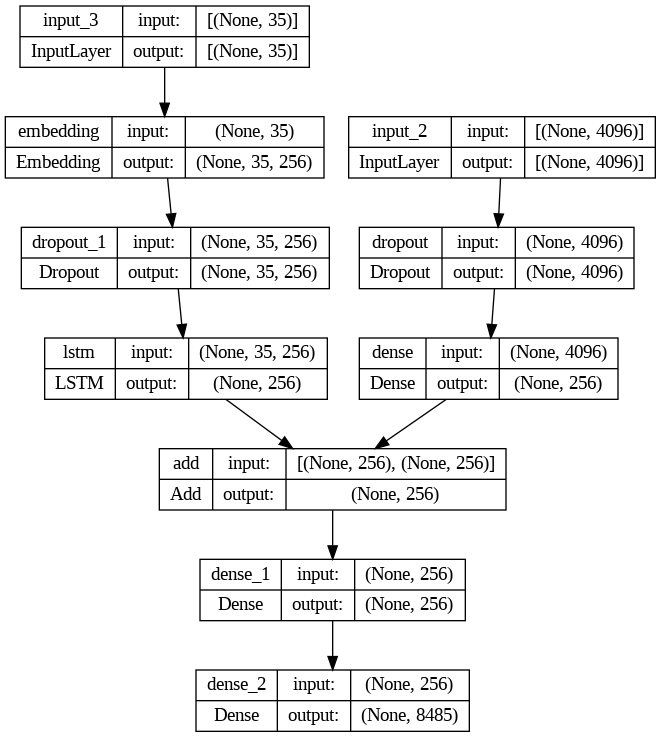

In [23]:
plot_model(model, show_shapes=True)                      # plot the model

The model is trained using a loop for a specified number of epochs and batch size. Here, epochs --> 20 and batch_size --> 32.

During each epoch, the model is trained by iterating over the batches of data generated by the data generator. The model's parameters are updated using the optimizer and the specified loss function. This process is repeated for the specified number of epochs, gradually improving the model's performance over time.

In [24]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)          # create data generator
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)                 # fit for one epoch

227/227 [==============================] - 1327s 6s/step - loss: 2.1864


### **Generate captions for the Image**

The **"idx_to_word"** function takes an integer (index) and a tokenizer as input and returns the corresponding word from the tokenizer's word-to-index mapping.

In [27]:
def idx_to_word(integer, tokenizer):                # iterates over items in word-to-index mapping of tokenizer
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Now, defines a function **"predict_caption"** that generates a caption for an image using a trained model. 

The **"predict_caption"** function takes an image and uses the trained model, along with the tokenizer and maximum caption length, to generate a caption for the image. It iteratively predicts the next word in the sequence until it reaches the maximum length or encounters the end sequence tag. The generated caption is returned as the output of the function.

In [28]:
def predict_caption(model, image, tokenizer, max_length):                    # generate caption for an image
    in_text = 'startseq'                            # add start tag for generation process
    for i in range(max_length):                     # iterate over the max length of sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]                # encode input sequence
        sequence = pad_sequences([sequence], max_length)                 # pad the sequence
        yhat = model.predict([image, sequence], verbose=0)               # predict next word
        yhat = np.argmax(yhat)                             # get index with high probability
        word = idx_to_word(yhat, tokenizer)                # convert index to word
        if word is None:                                # stop if word not found
            break
        in_text += " " + word                           # append word as input for generating next word
        if word == 'endseq':                     # stop if we reach end tag
            break
      
    return in_text

Now, the model's performance is evaluated using the test data. 

The **"BLEU scores"** provide an evaluation of how well the predicted captions match the actual captions. A higher BLEU score indicates a higher similarity between the predicted and actual captions.

In [29]:
actual, predicted = list(), list()                          # validate with test data

for key in tqdm(test):
    captions = mapping[key]                         # get actual caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)          # predict the caption for image
    actual_captions = [caption.split() for caption in captions]               # split into words
    y_pred = y_pred.split()
    actual.append(actual_captions)                 # append to the list
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))                 # calcuate BLEU score
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.536437
BLEU-2: 0.312072


The **"generate_caption"** function takes an image name as input and generates a caption for that image using the trained model.

By calling the **"generate_caption"** function with an image name, you can see the actual captions associated with the image and the predicted caption generated by the model. Additionally, the function displays the image itself using Matplotlib.

In [30]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------ACTUAL---------------------')
    for caption in captions:
        print(caption)
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)             # predict the caption
    print('--------------------PREDICTED--------------------')
    print(y_pred)
    plt.imshow(image)

Now generate caption for the image by using trained model.

---------------------ACTUAL---------------------
startseq "a dog shakes its head near the shore red ball next to it ." endseq
startseq white dog shakes on the edge of beach with an orange ball endseq
startseq "dog with orange ball at feet stands on shore shaking off water" endseq
startseq white dog playing with red ball on the shore near the water endseq
startseq white dog with brown ears standing near water with head turned to one side endseq
--------------------PREDICTED--------------------
startseq dog with white toy in its mouth is running through shallow water endseq


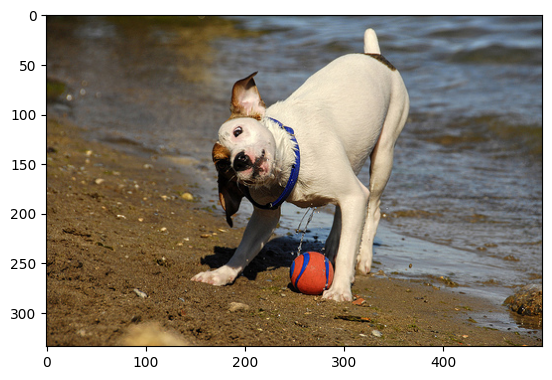

In [32]:
generate_caption("1012212859_01547e3f17.jpg")

---------------------ACTUAL---------------------
startseq cyclist is riding bicycle on curved road up hill endseq
startseq man in aerodynamic gear riding bicycle down road around sharp curve endseq
startseq man on mountain bike is pedaling up hill endseq
startseq "man bicycle up road while cows graze on hill nearby ." endseq
startseq the biker is riding around curve in the road endseq
--------------------PREDICTED--------------------
startseq man rides bicycle on curved curve on road endseq


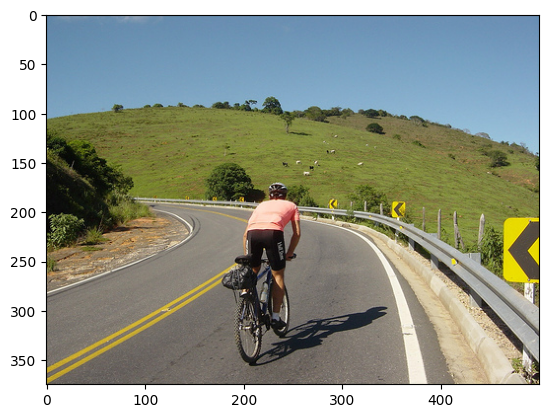

In [33]:
generate_caption("110595925_f3395c8bd6.jpg")

## **Test the Real Image**

A pre-trained **VGG16 model** is loaded and modified.

The modified model (vgg_model) retains the convolutional layers of the VGG16 model up to the second-to-last layer. It can be used to extract image features from input images by passing the images through the modified VGG16 model.

In [34]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)           # restructure the model

Now, you can generate a caption for the input image using the pre-trained VGG16 model to extract image features and the trained caption generation model to generate the caption.

In [39]:
image_path = '/content/drive/MyDrive/image_caption/Images/1286408831_05282582ed.jpg'
image = load_img(image_path, target_size=(224, 224))                # load image
image = img_to_array(image)                    # convert image pixels to numpy array
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))          # reshape data for model
image = preprocess_input(image)                # preprocess image for vgg
feature = vgg_model.predict(image, verbose=0)            # extract features
predict_caption(model, feature, tokenizer, max_length)          # predict from the trained model

'startseq young boy wearing green shirt peeks out at the camera endseq'

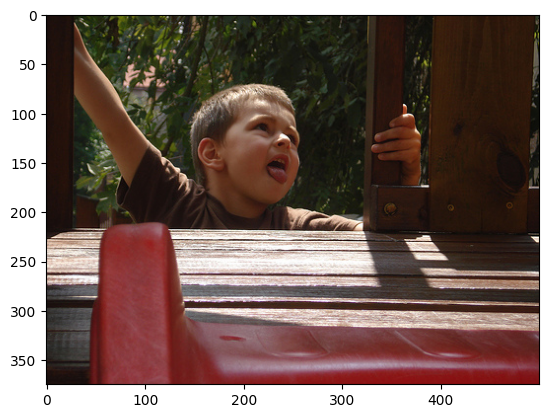

In [40]:
I=image = Image.open(image_path)
plt.imshow(I)